## Лабортаторная работа №6

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств слоя Кохонена, карты Кохонена, а также сетей векторного квантования, обучаемых с уителем, алгоритма обучения, а также применение сетей в задачах кластреизации и классификации.

In [1]:
import numpy as np
import pylab
import copy
import sklearn as skl

import torch
import torch.nn as nn
from tqdm import tqdm

### Задание 1. Слой Кохонена для кластеризации.

In [9]:
def plot_dataset(pts):
    for i in pts:
        pylab.plot(i[0],i[1],'o',color = [0,0,1])
    pylab.show()
    
def plot_dataset_by_classes(pts,lbls):
    for i in range(len(pts)):
        pylab.plot(pts[i][0],pts[i][1],'o',color = [lbls[i]/np.max(lbls),(lbls[i]%2 == 0) + 0,1 - lbls[i]/np.max(lbls)])
    pylab.show()
    
def plot_dataset_by_classes_cl(pts,lbls,centers):
    for i in range(len(pts)):
        pylab.plot(pts[i][0],pts[i][1],'o',color = [lbls[i]/np.max(lbls),(lbls[i]%2 == 0) + 0,1 - lbls[i]/np.max(lbls)])
    for i in centers:
        pylab.plot(i[0],i[1],'s',color = [0,0,0])
    pylab.show()

In [10]:
from sklearn.datasets import make_blobs
train_xx,y = make_blobs(n_samples=1000, centers=8, n_features=2,random_state = 10)

#### Сгенерированный датасет:

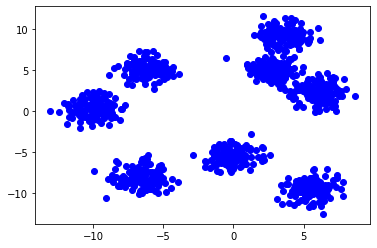

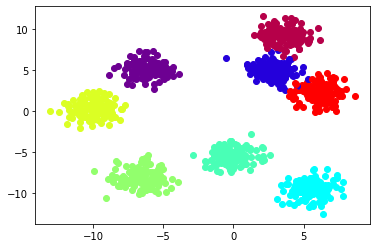

In [88]:
plot_dataset(train_xx)
plot_dataset_by_classes(train_xфx,y)

#### Слой Кохонена:

In [89]:
class cohonenLayer():
    def __init__ (self,classes):
        self.wts = np.random.random([classes,2])
        
    def train(self,inputs,n_epoch,lr = 0.5):
        
        for epoch in range(n_epoch):
            cur_elm = inputs[int(np.random.random()*len(inputs))]
            distances = np.zeros(len(self.wts))
            for i in range(len(self.wts)):
                dist = np.sqrt(((cur_elm - self.wts[i])**2).sum())
                distances[i] = dist
            self.wts[np.argmin(distances)] += lr*(cur_elm - self.wts[np.argmin(distances)])
            
    def predict(self,pt):
        res = np.zeros(len(self.wts))
        for i in range(len(self.wts)):
            res[i] = np.sqrt(((pt - self.wts[i])**2).sum())
        return np.argmin(res)

In [90]:
test_layer = cohonenLayer(8)

In [91]:
test_layer.train(train_xx,2000)

In [92]:
pred_lbl = []
for pt in train_xx: 
    pred_lbl.append(test_layer.predict(pt))
pred_lbl = np.array(pred_lbl)

#### Результат кластеризации:

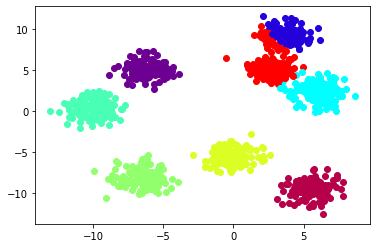

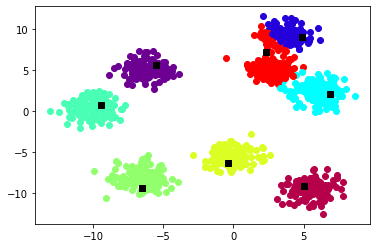

In [99]:
plot_dataset_by_classes(train_xx,pred_lbl)
plot_dataset_by_classes_cl(train_xx,pred_lbl,test_layer.wts)

### Задание 2. Карта Кохонена

In [3]:
def visualise(matr): #представить двумерный массив в виде черно-белой картинки
    pylab.figure(figsize = (matr.shape[1]/10,matr.shape[0]/10))
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            pylab.plot(j,matr.shape[0] - i,'s',color = (matr[i][j][0],matr[i][j][1],0))
    pylab.show()

In [4]:
def h(t,dist):
    return np.exp(-dist)

In [5]:
class cohonenMap():
    def __init__(self,shape):
        self.shape = shape
        self.mesh = np.random.random([self.shape[0],self.shape[1],2])
    
    def expand(self,examples,n_epoch = 10, h = h, radius = 5):
        rad = radius
        for epoch in range(n_epoch):     
            lr = n_epoch/(epoch + n_epoch)
            selected_node = examples[int(np.random.random()*len(examples))]
            tmp = self.mesh - selected_node

            tmp_norm = (np.abs(tmp).sum(axis = 2)) #не l2, но вроде норма

            min_val = np.min(tmp_norm)
            min_crd = np.argmin(tmp_norm)
            ril_min_crd = [int(min_crd / self.shape[0]),int(min_crd % self.shape[0])]
            
            for i in range(ril_min_crd[0] - rad,ril_min_crd[0] + rad):
                for j in range(ril_min_crd[1] - rad,ril_min_crd[1] + rad):
                    if(i >= 0 and j >= 0 and i < self.mesh.shape[0] and j < self.mesh.shape[1]):
                        dst = np.sqrt((ril_min_crd[0] - i)**2 + (ril_min_crd[1] - j)**2)
                        
                        self.mesh[i,j] -= tmp[i,j]*h(epoch,dst/rad)*lr
                        #self.mesh[i,j] -= tmp[ril_min_crd[1],ril_min_crd[0]]*h(epoch,dst/rad)*lr
                        
            if(rad > 1):
                rad -= 1
                
        
    def plot(self):
        tmp = np.abs(self.mesh / np.max(np.abs(self.mesh)))
        visualise(tmp)

#### Нахождение центров кластеров

In [239]:
test_map = cohonenMap([2,4])
test_map.expand(train_xx,radius = 4, n_epoch = 10000)

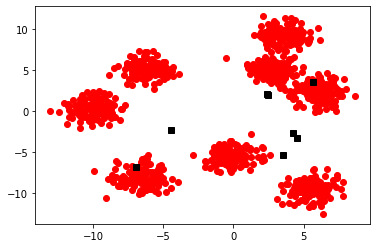

In [240]:
plot_dataset_by_classes_cl(train_xx,[1 for i in train_xx],test_map.mesh.reshape(8,2))

#### Карта большего размера

In [244]:
test_map = cohonenMap([20,20])
test_map.expand(train_xx,radius = 10, n_epoch = 10000)

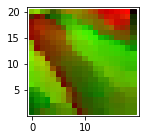

In [245]:
test_map.plot()

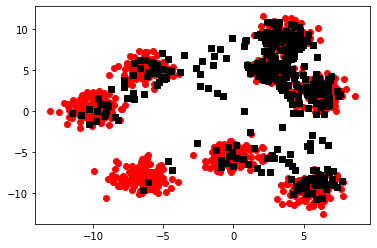

In [246]:
plot_dataset_by_classes_cl(train_xx,[1 for i in train_xx],test_map.mesh.reshape(400,2))

### Задание 3. Задача коммивояжера

In [211]:
class cohonenMap():
    def __init__(self,shape):
        self.shape = shape
        self.mesh = np.random.random([self.shape[0],self.shape[1],2])
    
    def expand(self,examples,n_epoch = 10, h = h, radius = 5):
        rad = radius
        for epoch in range(n_epoch):     
            lr = n_epoch/(epoch + n_epoch)
            selected_node = examples[int(np.random.random()*len(examples))]
            tmp = self.mesh - selected_node

            tmp_norm = (np.abs(tmp).sum(axis = 2)) #не l2, но вроде норма

            min_val = np.min(tmp_norm)
            min_crd = np.argmin(tmp_norm)
            ril_min_crd = [int(min_crd / self.shape[1]),int(min_crd % self.shape[1])]
            
            #номер города в выходном слое
            no_outer = ril_min_crd[1]
            
            for i in range(ril_min_crd[0] - rad,ril_min_crd[0] + rad):
                for j in range(ril_min_crd[1] - rad,ril_min_crd[1] + rad):
                    #прохождение через границу
                    i = i % self.mesh.shape[0]
                    j = j % self.mesh.shape[1]
                    #if(i >= 0 and j >= 0 and i < self.mesh.shape[0] and j < self.mesh.shape[1]):

                    dst = np.sqrt((ril_min_crd[0] - i)**2 + (ril_min_crd[1] - j)**2)

                    self.mesh[i,j] -= tmp[i,j]*h(epoch,dst/rad)*lr
                    #self.mesh[i,j] -= tmp[ril_min_crd[1],ril_min_crd[0]]*h(epoch,dst/rad)*lr

                    
            if(rad > 1):
                rad -= 1
                
    def closest(self,vec):
        
        selected_node = vec
        tmp = self.mesh - selected_node

        tmp_norm = (np.abs(tmp).sum(axis = 2)) #не l2, но вроде норма

        min_val = np.min(tmp_norm)
        min_crd = np.argmin(tmp_norm)
        ril_min_crd = [int(min_crd / self.shape[1]),int(min_crd % self.shape[1])]

        #номер города в выходном слое
        return ril_min_crd
        
        
    def plot(self):
        tmp = np.abs(self.mesh / np.max(np.abs(self.mesh)))
        visualise(tmp)

In [283]:
cities = np.random.random([20,2])

In [284]:
test_map = cohonenMap([1,20])
test_map.expand(cities,radius = 5, n_epoch = 10000)

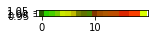

In [285]:
test_map.plot()

In [286]:
route = []
for x in cities:
    route.append(test_map.closest(x)[1])
route = np.array(route)

In [287]:
route

array([ 9,  4,  1,  0,  1,  4,  3,  6, 12, 10, 16, 14,  8,  2,  0,  0, 18,
        3,  7,  5])

In [288]:
def display_route(cities,order):
    for i in cities:
        pylab.plot(i[0],i[1],'o',color = [0,0,1])
        
    for num in range(len(route)):
        for i in range(len(route)):
            if(route[i] == num):
                for numnext in range(num + 1,len(route)): #возможные индексы следующего города
                    found = 0
                    for j in range(len(route)): #поиск города с соответствующим индексом
                        #print("-- {} {}\n".format(route[j],numnext))
                        if(route[j] == numnext):
                            print("{}:\t from node: {} \tto {} \t\t|\t ({}) -> ({})".format(num,i,j,cities[i],cities[j]))
                            found = 1
                            pylab.plot([cities[i][0],cities[j][0]],[cities[i][1],cities[j][1]],color = [1,num/len(route),0])
                            
                    if(found == 1):
                        break
                        
        
        
    pylab.show()

0:	 from node: 3 	to 2 		|	 ([0.13918294 0.04510845]) -> ([0.16540635 0.82354954])
0:	 from node: 3 	to 4 		|	 ([0.13918294 0.04510845]) -> ([0.02069403 0.96802678])
0:	 from node: 14 	to 2 		|	 ([0.13713818 0.09950256]) -> ([0.16540635 0.82354954])
0:	 from node: 14 	to 4 		|	 ([0.13713818 0.09950256]) -> ([0.02069403 0.96802678])
0:	 from node: 15 	to 2 		|	 ([0.19114129 0.14737807]) -> ([0.16540635 0.82354954])
0:	 from node: 15 	to 4 		|	 ([0.19114129 0.14737807]) -> ([0.02069403 0.96802678])
1:	 from node: 2 	to 13 		|	 ([0.16540635 0.82354954]) -> ([0.30368346 0.92790086])
1:	 from node: 4 	to 13 		|	 ([0.02069403 0.96802678]) -> ([0.30368346 0.92790086])
2:	 from node: 13 	to 6 		|	 ([0.30368346 0.92790086]) -> ([0.46562166 0.8078606 ])
2:	 from node: 13 	to 17 		|	 ([0.30368346 0.92790086]) -> ([0.3918983  0.88264813])
3:	 from node: 6 	to 1 		|	 ([0.46562166 0.8078606 ]) -> ([0.83017697 0.94696334])
3:	 from node: 6 	to 5 		|	 ([0.46562166 0.8078606 ]) -> ([0.79664982 0.923175

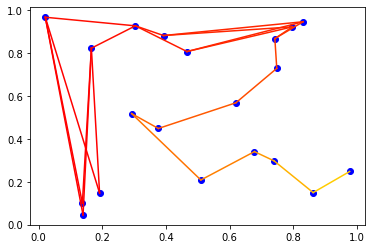

In [289]:
display_route(cities,route)

### Задание 4. LVQ сеть

#### Датасет для классификации:

In [273]:
data_c1 = [-0.3,-0.3,-1.1,-1.1,1.1,0.5,0,0.2,-0.7,-0.3,0.1,-0.3]
data_c2 = [1.4,0.3,-0.4,0.7,-0.5,-0.7,0.9,-0.5,-0.2,-0.5,0.7,-0.3]
data_lb = [1,1,1,1,1,1,1,1,-1,-1,1,-1]

In [274]:
examples = np.array([[data_c1[i],data_c2[i]] for i in range(len(data_c1))])
examples = examples / np.max(examples)
examples

array([[-0.21428571,  1.        ],
       [-0.21428571,  0.21428571],
       [-0.78571429, -0.28571429],
       [-0.78571429,  0.5       ],
       [ 0.78571429, -0.35714286],
       [ 0.35714286, -0.5       ],
       [ 0.        ,  0.64285714],
       [ 0.14285714, -0.35714286],
       [-0.5       , -0.14285714],
       [-0.21428571, -0.35714286],
       [ 0.07142857,  0.5       ],
       [-0.21428571, -0.21428571]])

In [285]:
data_lb = np.array((np.array(data_lb) + 1) / 2)
data_lb

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.])

In [350]:
class cohonenLayer(nn.Module):
    def __init__ (self,classes):
        super(cohonenLayer, self).__init__()
        self.wts = np.random.random([classes,2])
        
    def train(self,inputs,n_epoch,lr = 0.5):
        
        for epoch in range(n_epoch):
            cur_elm = inputs[int(np.random.random()*len(inputs))]
            distances = np.zeros(len(self.wts))
            for i in range(len(self.wts)):
                dist = np.sqrt(((cur_elm - self.wts[i])**2).sum())
                distances[i] = dist
            self.wts[np.argmin(distances)] += lr*(cur_elm - self.wts[np.argmin(distances)])
            
    def predict(self,pt):
        res = np.zeros(len(self.wts))
        for i in range(len(self.wts)):
            res[i] = np.sqrt(((pt - self.wts[i])**2).sum())
        return np.argmin(res)
    
    def __call__ (self,x):        
        res = np.zeros(len(self.wts))
        for i in range(len(self.wts)):
            res[i] = np.sqrt(((x - self.wts[i])**2).sum())
        return torch.tensor(res,dtype = torch.float32)

#### Сеть состоит из слоя кохонена, который выволняет кластеризацию и линейного слоя, который определяет лейбл для каждого кластера:

In [357]:
model = torch.nn.Sequential(
    cohonenLayer(2),
    torch.nn.Linear(2,2),
    torch.nn.Softmax(0)
)

In [358]:
def train(net,data_xx,data_lb,n_epochs,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.CrossEntropyLoss()
         ):
    
    optim = optimiser(model.parameters(),lr=lr)
    
    arr = []
    for i in tqdm(range(n_epochs)):
        for elm_ind in range(len(data_xx)):
            optim.zero_grad()
            
            loss = criterion(net(data_xx[elm_ind]),data_lb[elm_ind])
            loss.backward()
            optim.step()

        arr.append([i,
                    loss.detach().numpy(),
                   ])

    return np.array(arr)

In [359]:
model[0].train(examples,5000)
arr = train(model,examples,torch.tensor(data_lb,dtype = torch.long),5000,0.01)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 220.55it/s]


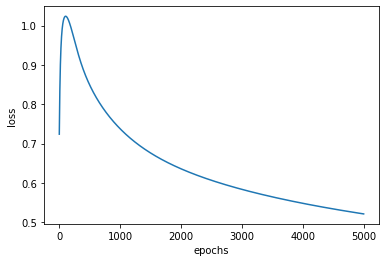

In [360]:
pylab.ylabel("loss")
pylab.xlabel("epochs")
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

In [361]:
pred_lbl = []
for pt in examples: 
    pred_lbl.append(np.argmax(model(pt).detach().numpy()))
pred_lbl = np.array(pred_lbl)

required result:


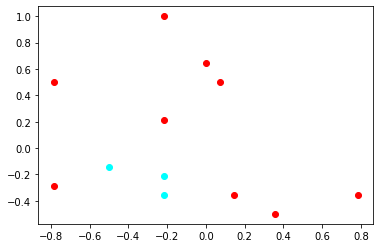

gained result:


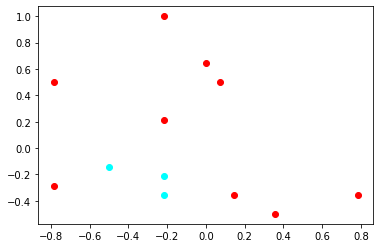

In [362]:
print("required result:")
plot_dataset_by_classes(examples,data_lb)
print("gained result:")
plot_dataset_by_classes(examples,pred_lbl)

#### Центры кластеров, определенные слоем кохонена:

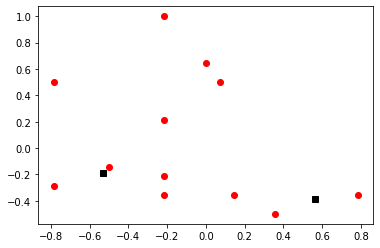

In [363]:
plot_dataset_by_classes_cl(examples,[1 for i in examples],model[0].wts)

#### Попробуем классифицировать датасет из задания 1.

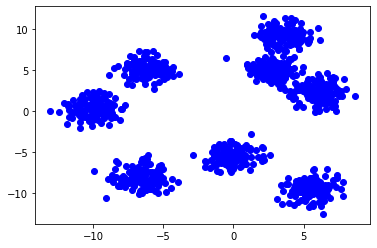

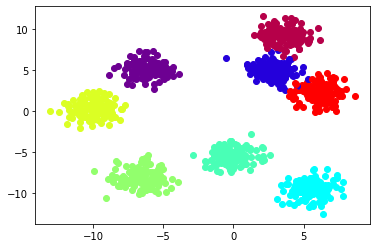

In [365]:
plot_dataset(train_xx)
plot_dataset_by_classes(train_xx,y)

In [368]:
model = torch.nn.Sequential(
    cohonenLayer(8),
    torch.nn.Linear(8,8),
    torch.nn.Softmax(0)
)

In [369]:
model[0].train(train_xx,5000)
arr = train(model,train_xx,torch.tensor(y,dtype = torch.long),1000,0.01)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:08<00:00,  2.05it/s]


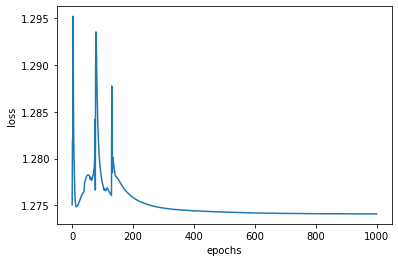

In [370]:
pylab.ylabel("loss")
pylab.xlabel("epochs")
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

In [378]:
pred_lbl = []
for pt in train_xx: 
    pred_lbl.append(np.argmax(model(pt).detach().numpy()))
pred_lbl = np.array(pred_lbl)

#### Результат классификации:

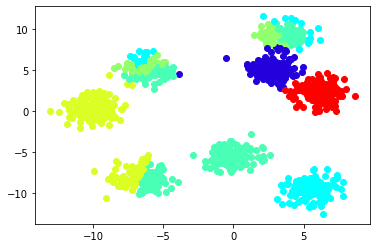

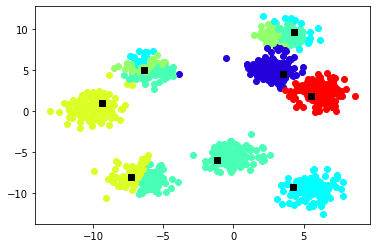

In [381]:
plot_dataset_by_classes(train_xx,pred_lbl)
plot_dataset_by_classes_cl(train_xx,pred_lbl,model[0].wts)

#### Настоящие классы:

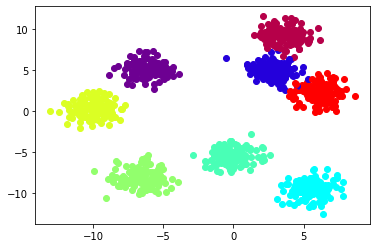

In [382]:
plot_dataset_by_classes(train_xx,y)

### Выводы

В ходе выполнения этой лабораторной работы я ознакомился со слоем Кохонена и картой Кохонена, получил опыт применения этих технологий для решения задачи кластеризации и классификации.